In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("redfin_data_cleaned.csv")

In [4]:
# create df1 that only has records of houses w/ prices above the 5th percentile but less than $1000000
df1 = df[(df.PRICE > df.PRICE.quantile(0.05)) & (df.PRICE < 1000000)]

# create df2 to select only revelant columns for model building from df1
df2 = df1[["CITY","MONTH","BEDROOMS","BATHROOMS","SQFT","LOTSIZE","YEARBUILT","PRICE"]]

In [5]:
# removing outliers
from scipy import stats

z_scores = stats.zscore(df2.PRICE)
abs_z_scores = np.abs(z_scores)
df2["z_scores"] = abs_z_scores

df_new = df2[df2["z_scores"]<3]

<ipython-input-5-2de96f065715>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["z_scores"] = abs_z_scores


In [6]:
# transform categorical column labels to numerical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_new.CITY = le.fit_transform(df1.CITY)
df_new.MONTH = le.fit_transform(df1.MONTH)

In [7]:
# create X and y variables 
X = df_new.iloc[:,0:7].values

y = df_new.PRICE

In [8]:
# solves numeric ordering of nominal categorical features 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(categories= "auto"),[0,1])],remainder='passthrough')

X = ct.fit_transform(X).toarray()

In [9]:
# data split, train and test set
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [40]:
# linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lm = LinearRegression()
lm.fit(X_train,y_train)

np.mean(cross_val_score(lm,X_train,y_train,scoring = "neg_mean_absolute_error",cv=10))

-59247.82187239474

0.553713385614652


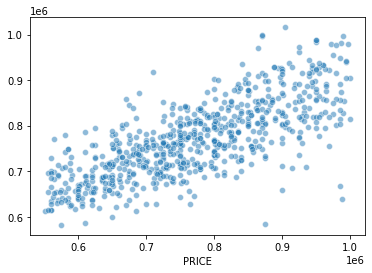

In [23]:
# linear regression model's predictions vs actual values 
Y_pred = lm.predict(X_test)

import seaborn as sns 
sns.scatterplot(y_test, Y_pred, alpha=0.5)

print(lm.score(X_test,y_test))

In [37]:
# random forest regressor model 
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train,y_train)

np.mean(cross_val_score(rf,X_train,y_train,scoring="neg_mean_absolute_error",cv=10))

-55233.336619545196

0.6456880273546595


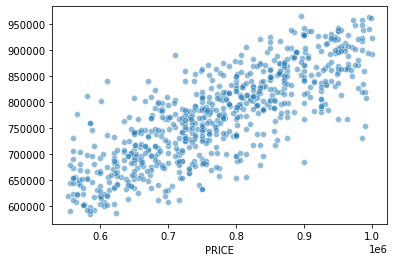

In [26]:
# random forest regressor model's predictions vs actual values 
r_pred = rf.predict(X_test)

sns.scatterplot(y_test, r_pred, alpha=0.5)

print(rf.score(X_test,y_test))

In [32]:
# gradient boosting regressor model 
import xgboost as xgb
from sklearn.metrics import mean_squared_error 

xgbr = xgb.XGBRegressor(verbosity = 0)
xgbr.fit(X_train,y_train)

np.mean(cross_val_score(xgbr,X_train,y_train,scoring="neg_mean_absolute_error",cv=10))

0.6417155094488759


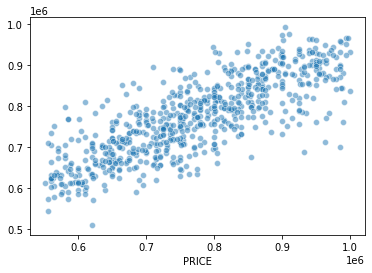

In [43]:
# gradient boosting regressor model's predictions vs actual values 
x_pred = xgbr.predict(X_test)

sns.scatterplot(y_test, x_pred, alpha=0.5)

print(rf.score(X_test,y_test))

In [53]:
# test ensembles, average error in each model 
from sklearn.metrics import mean_absolute_error

print("Linear Regression: ",mean_absolute_error(y_test,Y_pred))
print("Random Forest Regressor: ",mean_absolute_error(y_test,r_pred))
print("Gradient Boosting Regressor: ",mean_absolute_error(y_test,x_pred))

Linear Regression:  61027.31470836292
Random Forest Regressor:  53326.580085227266
Gradient Boosting Regressor:  53233.607599431816
